Разбиваем произведения авторов на чанки

In [1]:
import texts_splitter

chunk_size = 1000
texts_splitter.create_dataset_for_author("authors/Pushkin", "texts/Pushkin", chunk_size)
texts_splitter.create_dataset_for_author("authors/Dostoevsky", "texts/Dostoevsky", chunk_size)
texts_splitter.create_dataset_for_author("authors/Rowling", "texts/Rowling", chunk_size)

Файл "Dubrovsky.txt" успешно разбит на 137 кусков и сохранен в директории "texts/Pushkin".
Файл "Captain_daughter.txt" успешно разбит на 193 кусков и сохранен в директории "texts/Pushkin".
Файл "Idiot.txt" успешно разбит на 1304 кусков и сохранен в директории "texts/Dostoevsky".
Файл "Kubok_ognia.txt" успешно разбит на 1000 кусков и сохранен в директории "texts/Rowling".


Создаем датасет

In [2]:
from texts_loader import get_texts_from_dir
import random
import vectorization
from sklearn.preprocessing import LabelEncoder

Pushkin_texts = get_texts_from_dir("texts/Pushkin")
Dostoevsky_texts = get_texts_from_dir("texts/Dostoevsky")
Rowling_texts = get_texts_from_dir("texts/Rowling")

all_chunks = []
labels = []

# Добавьте куски текстов и соответствующие метки для каждого автора
all_chunks.extend(Pushkin_texts)
labels.extend(["Pushkin"] * len(Pushkin_texts))

all_chunks.extend(Dostoevsky_texts)
labels.extend(["Dostoevsky"] * len(Dostoevsky_texts))

all_chunks.extend(Rowling_texts)
labels.extend(["Rowling"] * len(Rowling_texts))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Перемешайте куски текстов и соответствующие метки
combined_data = list(zip(all_chunks, encoded_labels))
random.shuffle(combined_data)

# Разделите обратно на куски текстов и метки
shuffled_chunks, shuffled_labels = zip(*combined_data)

# Пример использования
# for chunk, label in zip(shuffled_chunks, shuffled_labels):
#     print(f"Label: {label}, Chunk: {chunk}")


tfidf_matrix, words, doc_names = vectorization.vectorize(shuffled_chunks)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danissimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/danissimo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Создаем обучающий и тестовый наборы данных

In [3]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, shuffled_labels, test_size=0.2, random_state=0)
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Создаем нейронную сеть

In [4]:
# Создание класса модели
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Определение параметров модели
input_size = X_train_tensor.shape[1]
hidden_size = 100
num_classes = len(set(labels))

# Инициализация модели, функции потерь и оптимизатора
model = TextClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Обучаем нейронную сеть

In [5]:
# Обучение модели
num_epochs = 150
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Вывод промежуточных результатов
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели на тестовом наборе
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy of the network on the test texts: {accuracy:.2%}')




Epoch [100/150], Loss: 0.0000
Accuracy of the network on the test texts: 99.05%


#### Расчёт метрик модели


Accuracy: 0.9905123339658444
Class 0: Precision=0.988929889298893, Recall=0.9925925925925926 
Class 1: Precision=0.9736842105263158, Recall=0.961038961038961 
Class 2: Precision=1.0, Recall=1.0 


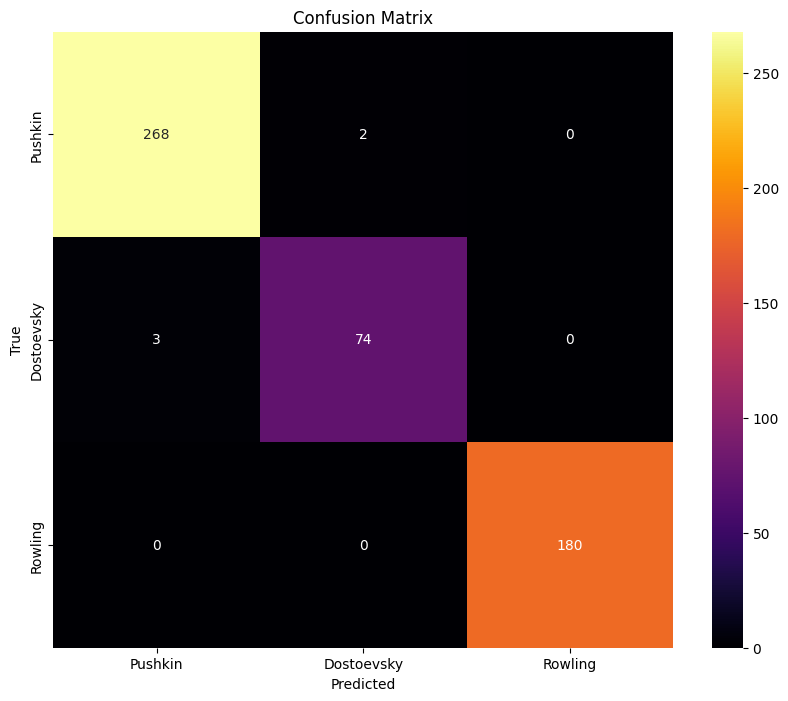

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

accuracy = accuracy_score(y_test_tensor.data, predicted)

precision = precision_score(y_test_tensor.data, predicted, average=None)

recall = recall_score(y_test_tensor.data, predicted, average=None)

conf_matrix = confusion_matrix(y_test_tensor.data, predicted)

print("Accuracy:", accuracy)
for class_label, prec, rec in zip(range(len(precision)), precision, recall):
    print(f'Class {class_label}: Precision={prec}, Recall={rec} ')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='inferno', xticklabels=['Pushkin','Dostoevsky','Rowling'], yticklabels=['Pushkin','Dostoevsky','Rowling'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


####Строим ROC кривую для многоклассовой классификации

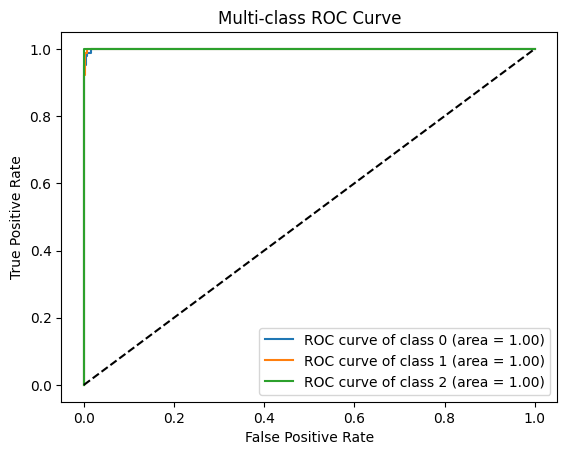

In [7]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_scores = outputs.numpy()
y_test_bin = label_binarize(y_test_tensor.numpy(), classes=np.unique(y_test_tensor.numpy()))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()
